# Sky brightness calculation

Sky light, sky bright,</br>
Only sky I'll see tonight,</br>
I wish I may, I wish I might,</br>
Know the sky I'll see tonight.

## boilerplate

Begin by marking the time of the most recent execution of this notebook.

In [1]:
import datetime
print(datetime.datetime.now())

2019-01-17 10:31:52.965899


Import `python` modules that are (effectively) always needed.

In [2]:
from IPython.core.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

Configure the notebook.

In [3]:
%matplotlib inline
display(HTML("<style>.container { width:90% !important; }</style>"))

mpl.rcParams['figure.figsize'] = (8, 5)
plt.style.use('ggplot')

Make the notebook repeatable, even if random numbers are used.

In [4]:
np.random.seed(6563)

import random
random.seed(21106)

## Example

Import `ConfigParser`, which is used by `skybright` to load the model parameters:

In [5]:
from ConfigParser import ConfigParser

Import `skybright` itself:

In [6]:
import skybright
from skybright import MoonSkyModel

Load the sky brightness model parameters:

In [7]:
model_config = ConfigParser() 
model_config.read('skybright.conf')
model_sky = MoonSkyModel(model_config)

`model_sky` is now a `python` callable object, and can be treated as a function that calculates sky brightness:

In [8]:
mjd = 58008.4 ;# MJD in UTC
ra = 36.45 ;# R.A. in decimal degrees
decl = -4.60 ;# declination in decimal degrees
band = 'i' ;# name of filter
model_sky(mjd, ra, decl, band)

19.28220794584352

### Vectorize for `numpy` or `pandas` use

Instead of calculating individual values, I often want to calculate sky brightness for a set of values, with parameters set, for example, in `numpy` arrays or `pandas` `DataFrame`s (ultimaltely the same thing). `numpy` offers a convenient tool for converting a standard `python` function to one that can be broadcast across array elements. Note that this is just syntacic sugar; using this approach doesn't actually move the iteration out of `python`, which would be required for performance improvement. Proper vectorization of `MoonSkyModel` is a to-do.

In [9]:
model_config = ConfigParser() 
model_config.read('skybright.conf')
model_sky = np.vectorize(MoonSkyModel(model_config))
df = pd.DataFrame({'mjd': np.arange(58007.8, 58008.4, 0.05)})
df['ra'] = np.full(df.mjd.values.shape, 10)
df['decl'] = np.full(df.mjd.values.shape, -30)
df['band'] = np.full(df.mjd.values.shape, 'g')
df['model_sky'] = model_sky(df.mjd, df.ra, df.decl, df.band)
df

skybright.py:472: UserWarning: Bad sky magnitude for mjd=58007.800000, ra=10.000000, decl=-30.000000, filter=g: Sky model does not work for pointings below the horizon!
  mjd, ra, decl, band, str(e)))
skybright.py:472: UserWarning: Bad sky magnitude for mjd=58007.800000, ra=10.000000, decl=-30.000000, filter=g: Sky model does not work for pointings below the horizon!
  mjd, ra, decl, band, str(e)))
skybright.py:472: UserWarning: Bad sky magnitude for mjd=58007.850000, ra=10.000000, decl=-30.000000, filter=g: Sky model does not work for pointings below the horizon!
  mjd, ra, decl, band, str(e)))
skybright.py:472: UserWarning: Bad sky magnitude for mjd=58007.900000, ra=10.000000, decl=-30.000000, filter=g: Sky model does not work for pointings below the horizon!
  mjd, ra, decl, band, str(e)))
skybright.py:472: UserWarning: Bad sky magnitude for mjd=58007.950000, ra=10.000000, decl=-30.000000, filter=g: Sky model does not work during the day
  mjd, ra, decl, band, str(e)))


,mjd,ra,decl,band,model_sky
0,58007.80,10,-30,g,NaN
1,58007.85,10,-30,g,NaN
2,58007.90,10,-30,g,NaN
3,58007.95,10,-30,g,NaN
4,58008.00,10,-30,g,21.460191
5,58008.05,10,-30,g,21.742090
6,58008.10,10,-30,g,21.996917
7,58008.15,10,-30,g,22.169754
8,58008.20,10,-30,g,20.914577
9,58008.25,10,-30,g,20.566191


# Compare modeled values with those in the DES DM database

To test the model, I compare the values calculated using it to those measured for DECam data by the DES Data Management pipeline.

## Load test data from DES data management

Import `easyaccess`, the `python` module for querying the DES DM database.

In [10]:
import easyaccess

Define the query to send to the DES DM database. The value for the extinction and photometric zeropoints were kindly provided be [Douglas Tucker](https://orcid.org/0000-0001-7211-5729) as being typical of DECam data. 

In [11]:
dm_sky_query = """WITH extctn AS (
SELECT DISTINCT band,
       CASE WHEN band='u' THEN 0.44
            WHEN band='g' THEN 0.20
            WHEN band='r' THEN 0.12
            WHEN band='i' THEN 0.10
            WHEN band='z' THEN 0.08
            WHEN band='Y' THEN 0.08
            ELSE 0.0
       END AS extinction,
       CASE WHEN band='u' THEN 23.550
            WHEN band='g' THEN 25.396
            WHEN band='r' THEN 25.501
            WHEN band='i' THEN 25.386
            WHEN band='z' THEN 25.056
            WHEN band='Y' THEN 23.976
            ELSE 0.0
       END AS zp
FROM prod.exposure
)
SELECT e.band, e.airmass, e.mjd_obs AS mjd, e.tradeg AS telra, e.tdecdeg AS teldec,
  x.zp - 2.5*log(10,f.skybrightness) + 2.5*log(10,0.263*0.263) - x.extinction*e.airmass AS skymag,
  x.extinction AS k
FROM prod.exposure e
JOIN prod.firstcut_eval f ON e.expnum = f.expnum
JOIN extctn x ON x.band = e.band
WHERE f.c_eff>0.98 AND NOT e.band='VR'
ORDER BY e.expnum ASC
"""

Send the query to the DES DM operations database, and read the results into a `pandas` `DataFrame`.

In [12]:
con = easyaccess.connect(section="desoper", quiet=True)
dm_sky = pd.read_sql_query(dm_sky_query, con)
con.close()

In [13]:
dm_sky.sample(4)

,BAND,AIRMASS,MJD,TELRA,TELDEC,SKYMAG,K
66904,g,1.26,58040.147858,35.664825,-6.411972,22.120734,0.20
18328,g,1.12,57068.083143,76.530208,-19.502861,22.029504,0.20
80227,z,1.14,58371.313382,27.553667,-58.816693,18.874574,0.08
19784,Y,1.09,57266.396017,26.538283,-42.720776,18.354922,0.08


In [14]:
dm_sky.describe()

,AIRMASS,MJD,TELRA,TELDEC,SKYMAG,K
count,90915.000000,90915.000000,90915.000000,90915.000000,90915.000000,90915.000000
mean,1.233681,57668.862745,107.683298,-29.787758,19.910432,0.119102
std,0.188713,473.427234,117.224352,20.938610,1.541839,0.049703
min,1.000000,56278.310240,0.000000,-88.022581,15.737674,0.080000
25%,1.090000,57294.122127,30.000208,-45.764193,18.600335,0.080000
50%,1.190000,57697.166697,52.650750,-30.428444,19.800876,0.100000
75%,1.330000,58047.013008,136.197164,-10.358875,21.342213,0.120000
max,2.510000,58493.200025,360.000000,23.474110,23.260001,0.440000


## Add `skybright` model calculated parameters to the queried `DataFrame`

Read the sky model parameters, and extract a few values we will need to calculate parameters we might want to look at.

In [15]:
model_config = ConfigParser() 
model_config.read('skybright.conf')
longitude = model_config.getfloat("Observatory Position", "longitude")
latitude = model_config.getfloat("Observatory Position", "latitude")
bands = model_config.get("sky", "filters").split()

In [16]:
sky = np.vectorize(MoonSkyModel(model_config))

Actually calculate the modeled values:

In [17]:
%%time
dm_sky['model_sky'] = sky(dm_sky.MJD, dm_sky.TELRA, dm_sky.TELDEC, dm_sky.BAND)

CPU times: user 33.7 s, sys: 464 ms, total: 34.2 s
Wall time: 33.7 s


Add additional parameters to the `DataFrame` so we can compare them with differences with the model, to look for trends.

In [18]:
%%time
dm_sky['sun_zd'] = np.vectorize(skybright.body_zd)('sun', latitude, longitude, dm_sky.MJD)
dm_sky['moon_zd'] = np.vectorize(skybright.body_zd)('moon', latitude, longitude, dm_sky.MJD)
dm_sky['moon_brightness'] = np.vectorize(skybright.moon_brightness)(dm_sky.MJD)
dm_sky['lst'] = np.degrees(np.vectorize(skybright.gmst_rad)(dm_sky.MJD) + np.radians(longitude))
dm_sky['ha'] = dm_sky.lst - dm_sky.TELRA
dm_sky['airmass'] = np.vectorize(skybright.airmass_rad)(np.vectorize(skybright.zd_rad)(np.radians(dm_sky.ha), np.radians(dm_sky.TELDEC), np.radians(latitude)))

CPU times: user 11.7 s, sys: 404 ms, total: 12.1 s
Wall time: 11.4 s


## Plot measured vs. modeled sky brightnesses

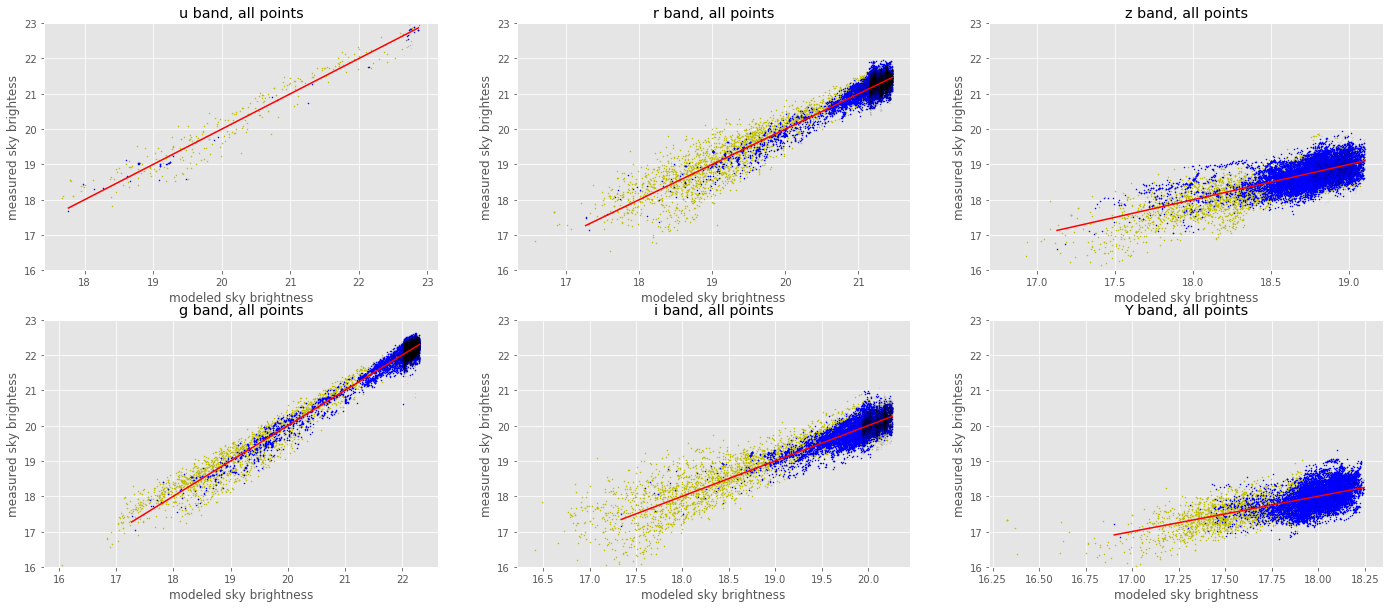

In [19]:
with mpl.rc_context(rc={'figure.figsize': (3*8, 2*5)}):
    fig, axes = plt.subplots(2, 3)
    for i, band in enumerate(bands):
        ax = axes[i%2, i/2]
        ax.set_title("%s band, all points" % band)
        twi = dm_sky.query('BAND == "%s" and sun_zd<108' % band).copy()
        twi.plot.scatter('model_sky', 'SKYMAG', s=1, c='y', ax=ax, ylim=(16, 23))
        
        moony = dm_sky.query('BAND == "%s" and sun_zd>108 and moon_zd<108' % band).copy()
        moony.sort_values('model_sky', inplace=True)
        moony.plot.scatter('model_sky', 'SKYMAG', s=1, c='b', ax=ax)
        ax.plot(moony.model_sky,  moony.model_sky, c='r')
        
        dark = dm_sky.query('BAND == "%s" and sun_zd>108 and moon_zd>108' % band).copy()
        dark.plot.scatter('model_sky', 'SKYMAG', s=1, c='k', alpha=0.05, ax=ax)
        
        ax.set_ylabel("measured sky brightess")
        ax.set_xlabel("modeled sky brightness")

## Plot residuals

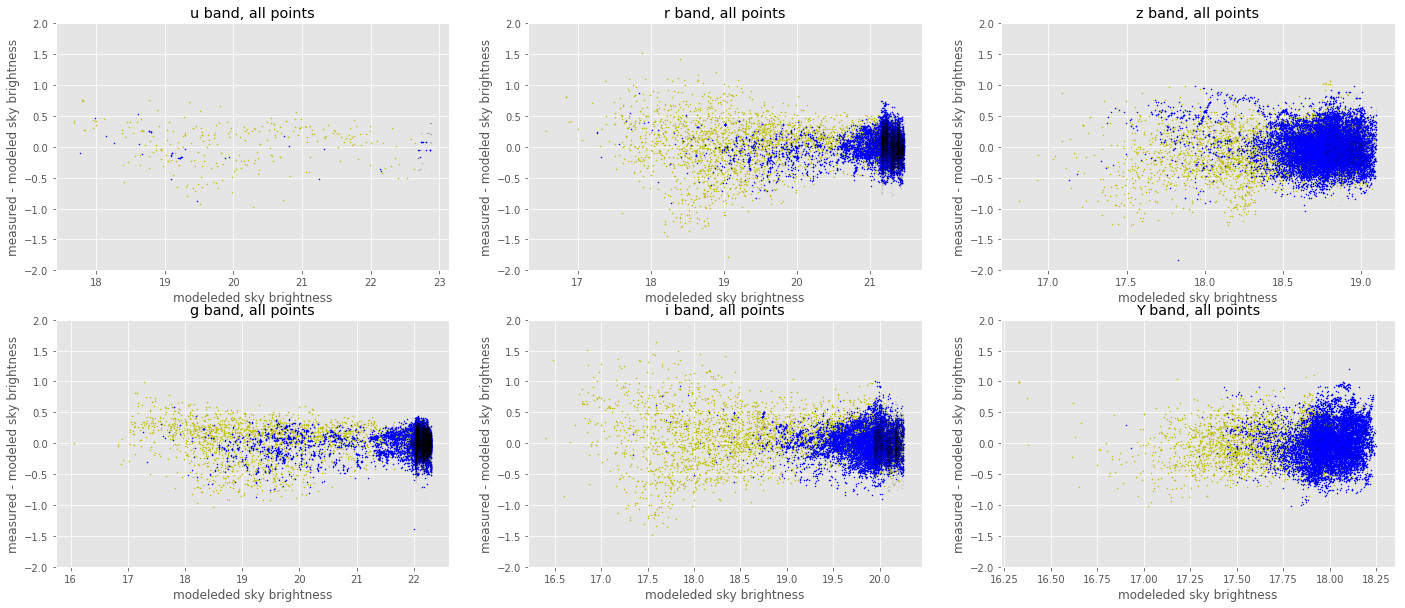

In [20]:
dm_sky['dmag'] = dm_sky.SKYMAG - dm_sky.model_sky
with mpl.rc_context(rc={'figure.figsize': (3*8, 2*5)}):
    fig, axes = plt.subplots(2, 3)
    for i, band in enumerate(bands):
        ax = axes[i%2, i/2]
        ax.set_title("%s band, all points" % band)

        twi = dm_sky.query('BAND == "%s" and sun_zd<108' % band).copy()
        twi.plot.scatter('model_sky', 'dmag', s=1, c='y', ylim=(-2, 2), ax=ax)
        
        moony = dm_sky.query('BAND == "%s" and sun_zd>108 and moon_zd<108' % band).copy()
        moony.sort_values('model_sky', inplace=True)
        moony.plot.scatter('model_sky', 'dmag', s=1, c='b', ax=ax)
        
        dark = dm_sky.query('BAND == "%s" and sun_zd>108 and moon_zd>108' % band).copy()
        dark.plot.scatter('model_sky', 'dmag', s=1, c='k', alpha=0.05, ax=ax)
        
        ax.set_ylabel("measured - modeled sky brightness")
        ax.set_xlabel("modeleded sky brightness")

Examine the statisticts of the residuals vs. the `skybright` model, and compare with residuals vs. a simple median:

In [21]:
summary_df = pd.DataFrame()
for band in bands:
    df = dm_sky.query('BAND == "%s"' % band)
    summary_df['%s_median_sub' % band] = (df.SKYMAG - df.SKYMAG.median()).describe()
    summary_df['%s_model_sub' % band] = (df.SKYMAG - df.model_sky).describe()
summary_df

,u_median_sub,u_model_sub,g_median_sub,g_model_sub,r_median_sub,r_model_sub,i_median_sub,i_model_sub,z_median_sub,z_model_sub,Y_median_sub,Y_model_sub
count,377.000000,377.000000,19259.000000,19259.000000,19067.000000,19067.000000,17276.000000,17276.000000,21501.000000,21501.000000,13435.000000,13435.000000
mean,0.187634,0.021515,-0.362881,0.005080,-0.250189,0.011465,-0.151975,0.019125,-0.032898,-0.022750,-0.013862,0.006396
std,1.578085,0.311644,1.016191,0.193943,0.791240,0.244901,0.659867,0.279771,0.405487,0.288379,0.387212,0.303689
min,-2.772883,-0.974319,-6.046257,-1.409848,-4.682425,-1.788111,-4.163000,-1.485532,-2.792441,-1.836637,-2.007795,-1.010650
25%,-1.331995,-0.179935,-0.241675,-0.114953,-0.272507,-0.127882,-0.305447,-0.153061,-0.222683,-0.212373,-0.262957,-0.205941
50%,0.000000,0.074610,0.000000,0.015952,0.000000,0.018216,0.000000,0.014460,0.000000,-0.028808,0.000000,0.003870
75%,1.699025,0.249435,0.158815,0.140788,0.180715,0.167990,0.235337,0.185391,0.208930,0.155702,0.242639,0.211069
max,2.821367,0.757275,0.525437,0.987652,0.751681,1.518457,1.154257,2.012697,1.214013,1.077599,1.356650,1.204916


## Compare measured sky magnitudes as a function of airmass with the model, for a full dark sky

"Full dark" in this context means no moon or twilight.

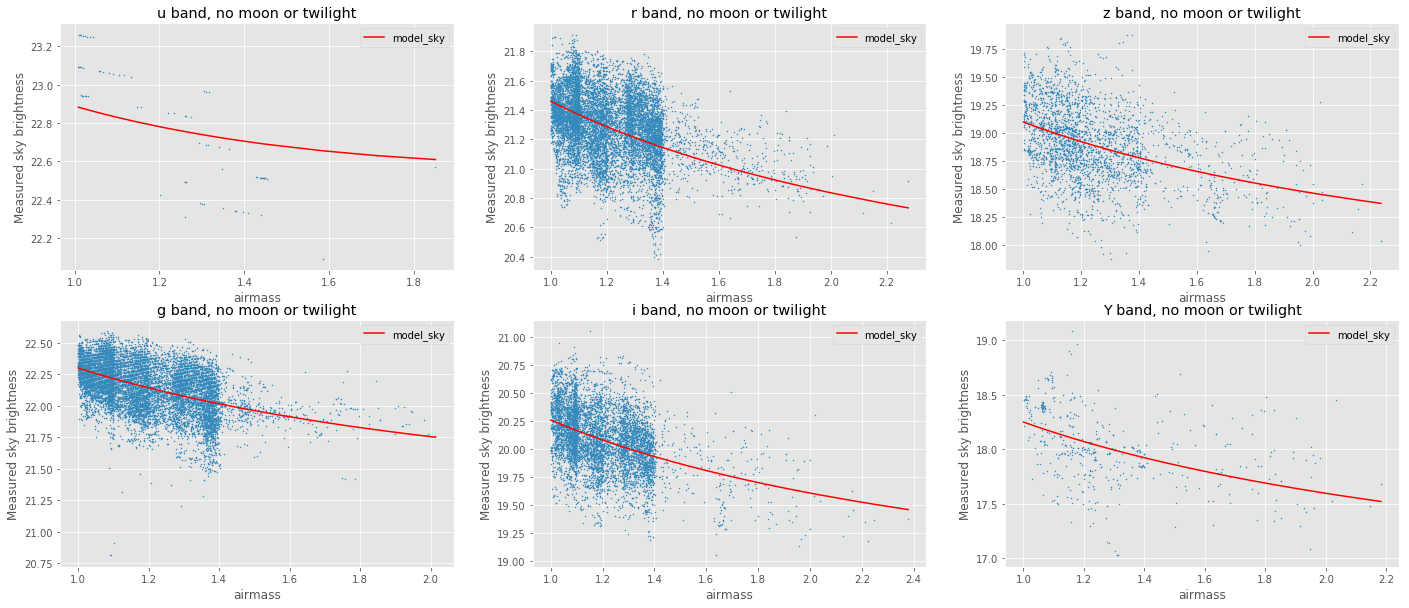

In [22]:
with mpl.rc_context(rc={'figure.figsize': (3*8, 2*5)}):
    fig, axes = plt.subplots(2, 3)
    for i, band in enumerate(bands):
        ax = axes[i%2, i/2]
        ax.set_title("%s band, no moon or twilight" % band)

        df = dm_sky.query('BAND == "%s" and sun_zd>108 and moon_zd>108' % band)
        df.plot.scatter('airmass', 'SKYMAG', s=1, ax=ax)
        df.sort_values('airmass').plot('airmass', 'model_sky', c='r', ax=ax)
        
        ax.set_ylabel("Measured sky brightness")

In [23]:
summary_df = pd.DataFrame()
for band in bands:
    df = dm_sky.query('BAND == "%s" and sun_zd>108 and moon_zd>108' % band)
    summary_df['%s_median_sub' % band] = (df.SKYMAG - df.SKYMAG.median()).describe()
    summary_df['%s_model_sub' % band] = (df.SKYMAG - df.model_sky).describe()
summary_df

,u_median_sub,u_model_sub,g_median_sub,g_model_sub,r_median_sub,r_model_sub,i_median_sub,i_model_sub,z_median_sub,z_model_sub,Y_median_sub,Y_model_sub
count,70.000000,70.000000,10864.000000,10864.000000,9965.000000,9965.000000,6110.000000,6110.000000,2546.000000,2546.000000,442.000000,442.000000
mean,-0.061918,-0.001841,-0.020395,0.001265,-0.017774,0.006326,-0.000565,0.002688,0.011131,-0.001716,0.019832,-0.000387
std,0.313733,0.253205,0.192243,0.169736,0.221614,0.209621,0.270967,0.246286,0.323796,0.295306,0.339869,0.311389
min,-0.743995,-0.562014,-1.360092,-1.409848,-0.924437,-0.789967,-1.041877,-0.808466,-1.010560,-0.967196,-0.967258,-0.958773
25%,-0.325875,-0.179788,-0.147308,-0.109724,-0.156252,-0.120291,-0.168338,-0.155962,-0.196272,-0.201899,-0.194582,-0.165398
50%,0.000000,0.068277,0.000000,0.008754,0.000000,0.013963,0.000000,-0.000132,0.000000,-0.010817,0.000000,-0.010917
75%,0.218680,0.217664,0.122382,0.127070,0.132574,0.153499,0.185933,0.168361,0.221190,0.195907,0.290651,0.198545
max,0.422347,0.384717,0.417906,0.459860,0.602432,0.595314,0.964350,0.933738,0.987402,1.077599,1.089589,0.981320


## Look at the correlation between successive residuals

If the residuals are highly correlated, then an offset for future exposures can be estimated from the residuals of past ones.

Text(0.5,0,'measured - modeled sky brightness at expnum-1')

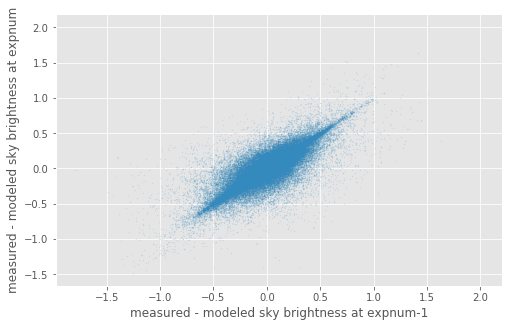

In [24]:
df = dm_sky.copy()
df['previous_MJD'] = df.MJD.shift(1)
df['previous_dmag'] = df.dmag.shift(1)
df.query('(MJD - previous_MJD) < (1.0/24.0)', inplace=True) ;# ignore gaps longer than an hour
ax = df.plot.scatter('previous_dmag', 'dmag', s=1, alpha=0.1)
ax.set_ylabel("measured - modeled sky brightness at expnum")
ax.set_xlabel("measured - modeled sky brightness at expnum-1")

(0, 100)

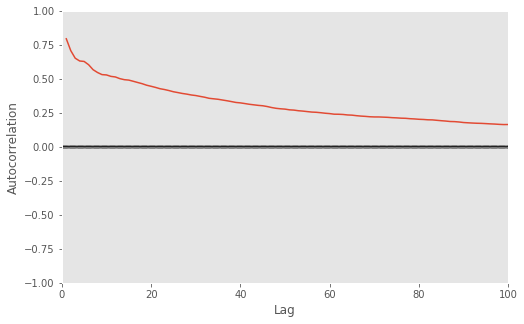

In [25]:
ax = pd.plotting.autocorrelation_plot(dm_sky.dmag)
ax.set_xlim((0, 100))